# Unlocking FIRE's potential
Galactic potentials from FIRE simulations

In [1]:
import os

import h5py as h5
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np

import gala.potential as gp
from gala.units import galactic

import astropy.units as u

import sys
sys.path.append("helpers")

import tomFIRE

In [2]:
from importlib import reload

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Attempt 1: Multi-component parametric model

## Mass enclosed
Work out the mass enclosed as a function of radius

In [4]:
reload(tomFIRE)

gas = tomFIRE.FIRESnapshot(particle_type="gas", min_t_form=-1 * u.Gyr)
dark_matter = tomFIRE.FIRESnapshot(particle_type="dark matter", min_t_form=-1 * u.Gyr)
stars = tomFIRE.FIRESnapshot(particle_type="star", min_t_form=-1 * u.Gyr)

In [5]:
r_range = np.geomspace(4e-2, 30, 100) * u.kpc

m_enc = {}
n_enc = {}

m_enc['total'] = np.zeros(len(r_range)) * u.Msun
n_enc['total'] = np.zeros(len(r_range))

for particles, label in zip([gas, dark_matter, stars], ["Gas", "Dark Matter", "Stars"]):
    m_enc[label] = [particles.m[particles.r < r].sum().value for r in r_range] * u.Msun
    n_enc[label] = np.array([(particles.r < r).sum() for r in r_range])
    m_enc["total"] += m_enc[label]
    n_enc['total'] += n_enc[label]

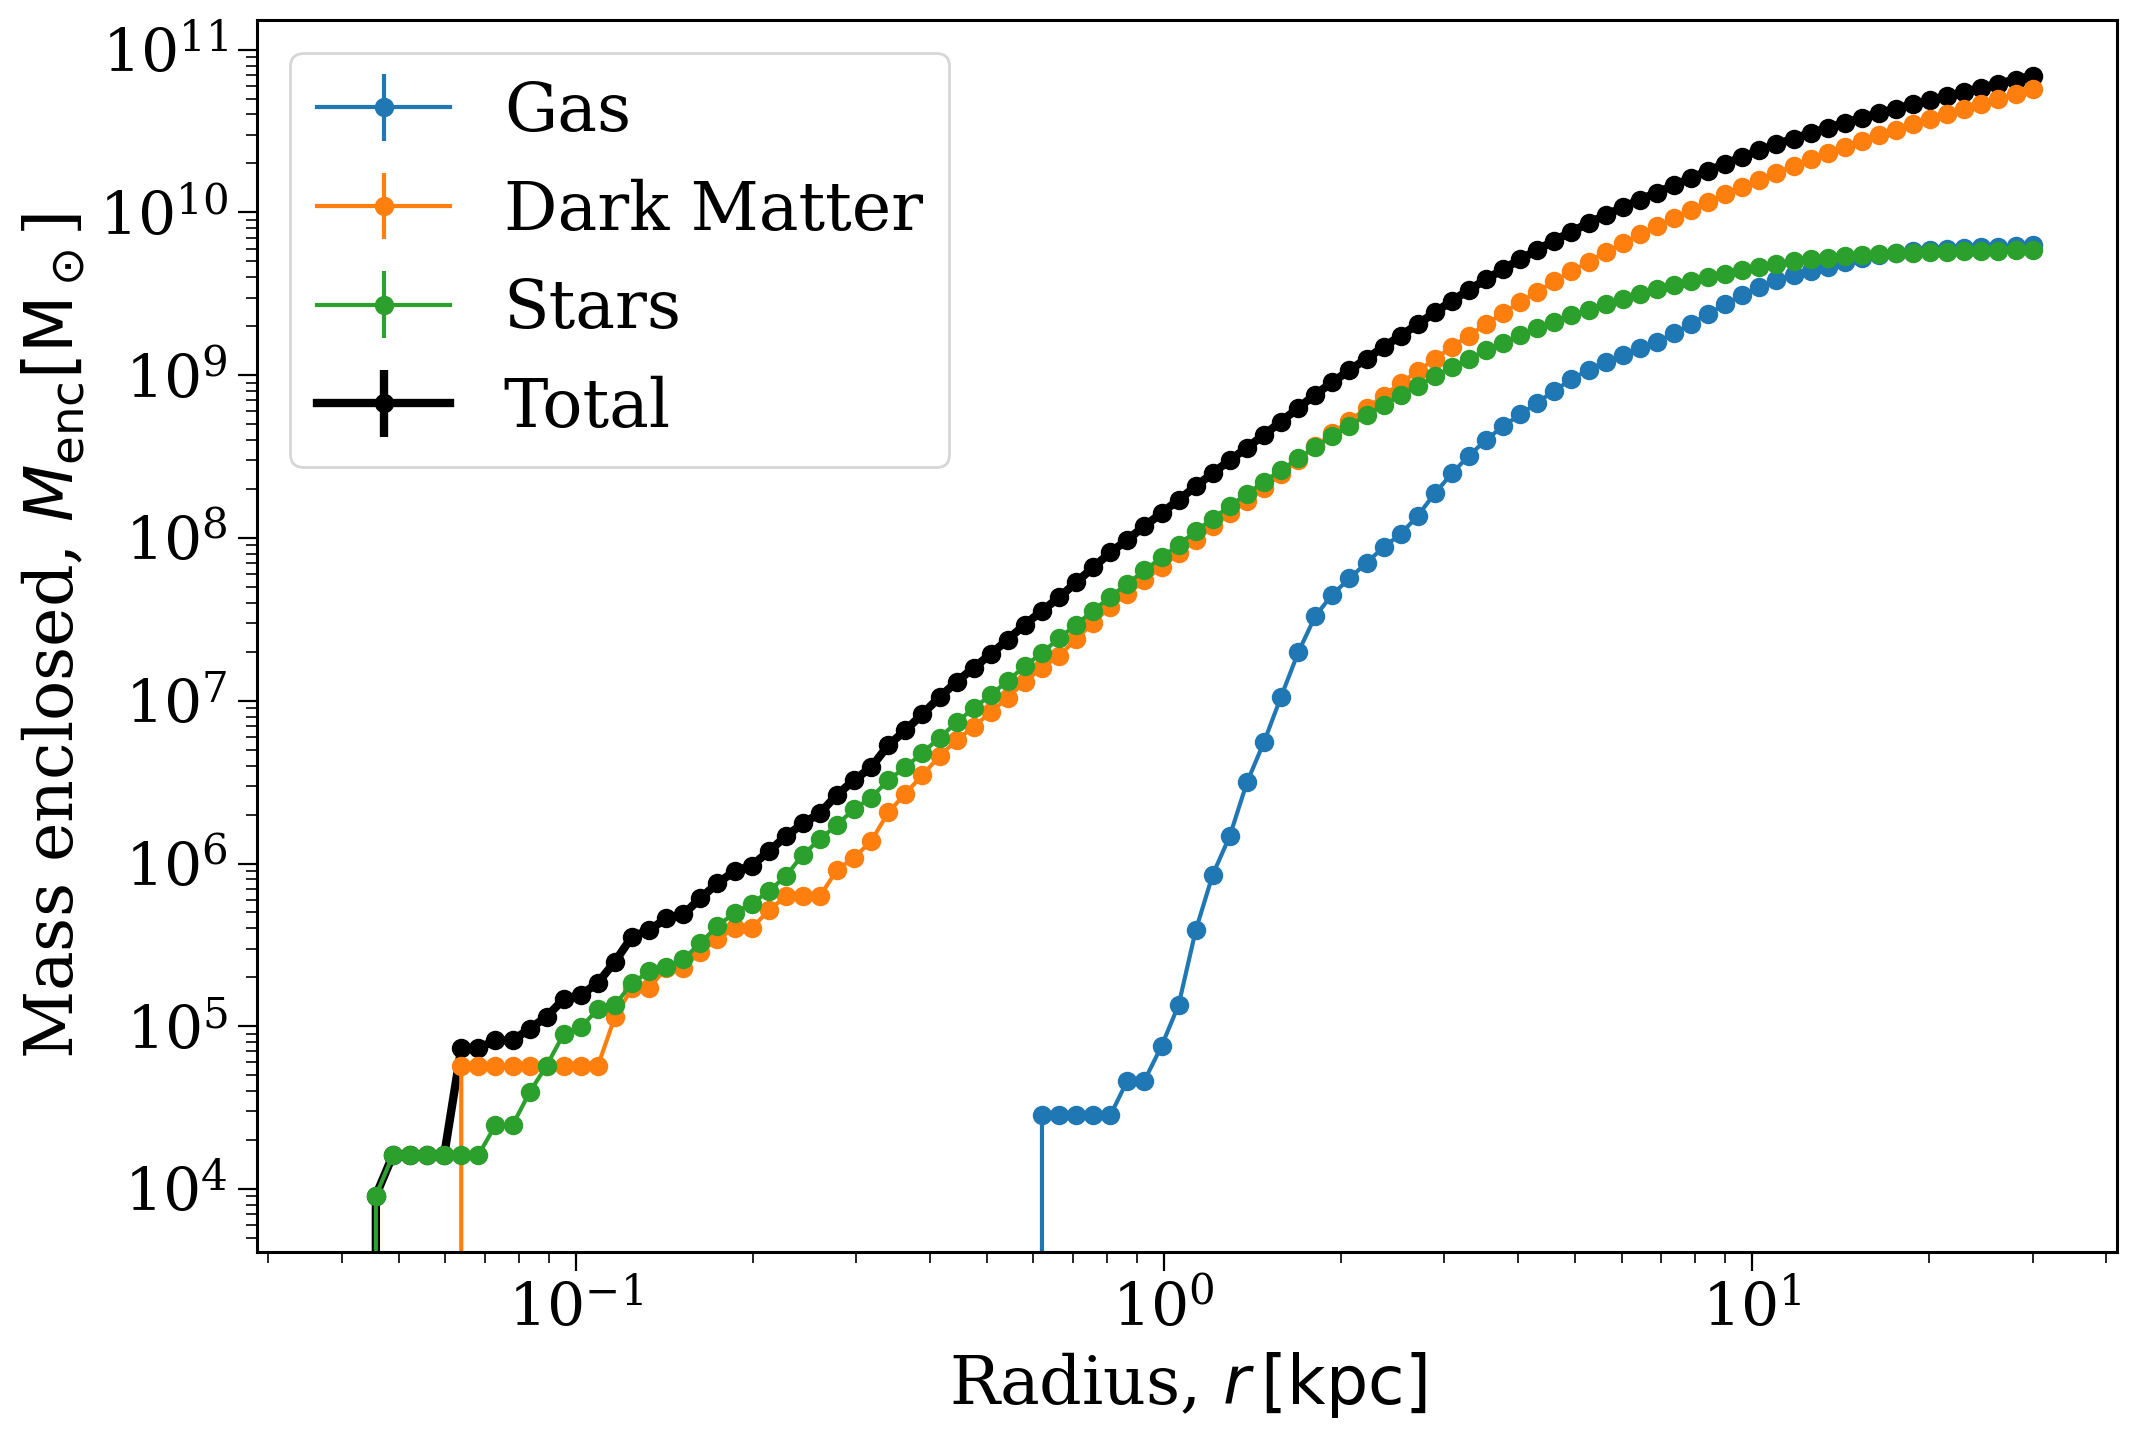

In [7]:
for label in ["Gas", "Dark Matter", "Stars"]: 
    plt.errorbar(r_range, m_enc[label].value, np.sqrt(m_enc[label].value), label=label, marker="o")
plt.errorbar(r_range, m_enc['total'].value, np.sqrt(m_enc['total'].value), label="Total", color="black", lw=3, zorder=-1, marker="o")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.xlabel(r"Radius, $r \, [\rm kpc]$")
plt.ylabel(r"Mass enclosed, $M_{\rm enc} [\rm M_\odot$]")
plt.show()

## Set up a Potential model for fitting

In [6]:
import gala.potential as gp
from gala.units import galactic

In [7]:
def get_potential(log_M_h, log_r_s, log_M_n, log_a, log_M_d, log_a_d, log_b_d, log_M_b, log_c_b):
    mw_potential = gp.CCompositePotential()
    mw_potential['bulge'] = gp.HernquistPotential(m=np.exp(log_M_b) * u.Msun, c=np.exp(log_c_b), units=galactic)
    mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=np.exp(log_M_d) * u.Msun, a=np.exp(log_a_d) * u.kpc, b=np.exp(log_b_d) * u.pc,
                                                     units=galactic)
    mw_potential['nucl'] = gp.HernquistPotential(m=np.exp(log_M_n), c=np.exp(log_a)*u.pc,
                                                 units=galactic)
    mw_potential['halo'] = gp.NFWPotential(m=np.exp(log_M_h), r_s=np.exp(log_r_s), units=galactic)

    return mw_potential

In [10]:
x0 = [np.log(6E10), np.log(20.), np.log(2E8), np.log(100.), np.log(6.8e9), np.log(3), np.log(280), np.log(5e8), np.log(1)]
init_potential = get_potential(*x0)

In [11]:
def err_func(p, r, Menc, Menc_err):
    pot = get_potential(*p)
    xyz = np.zeros((3, len(r)))
    xyz[0] = r
    model_menc = pot.mass_enclosed(xyz).to(u.Msun).value
    return (model_menc - Menc) / Menc_err

In [12]:
from scipy.optimize import leastsq

In [13]:
err = np.sqrt(m_enc["total"].value)
err[err == 0] = 1

In [14]:
p_opt, ier = leastsq(err_func, x0=x0, args=(r_range, m_enc["total"].value, err))
assert ier in range(1, 4+1), "least-squares fit failed!"
fit_potential = get_potential(*p_opt)

p_opt, ier = leastsq(err_func, x0=p_opt, args=(r_range, m_enc["total"].value, err))
assert ier in range(1, 4+1), "least-squares fit failed!"
double_fit_potential = get_potential(*p_opt)

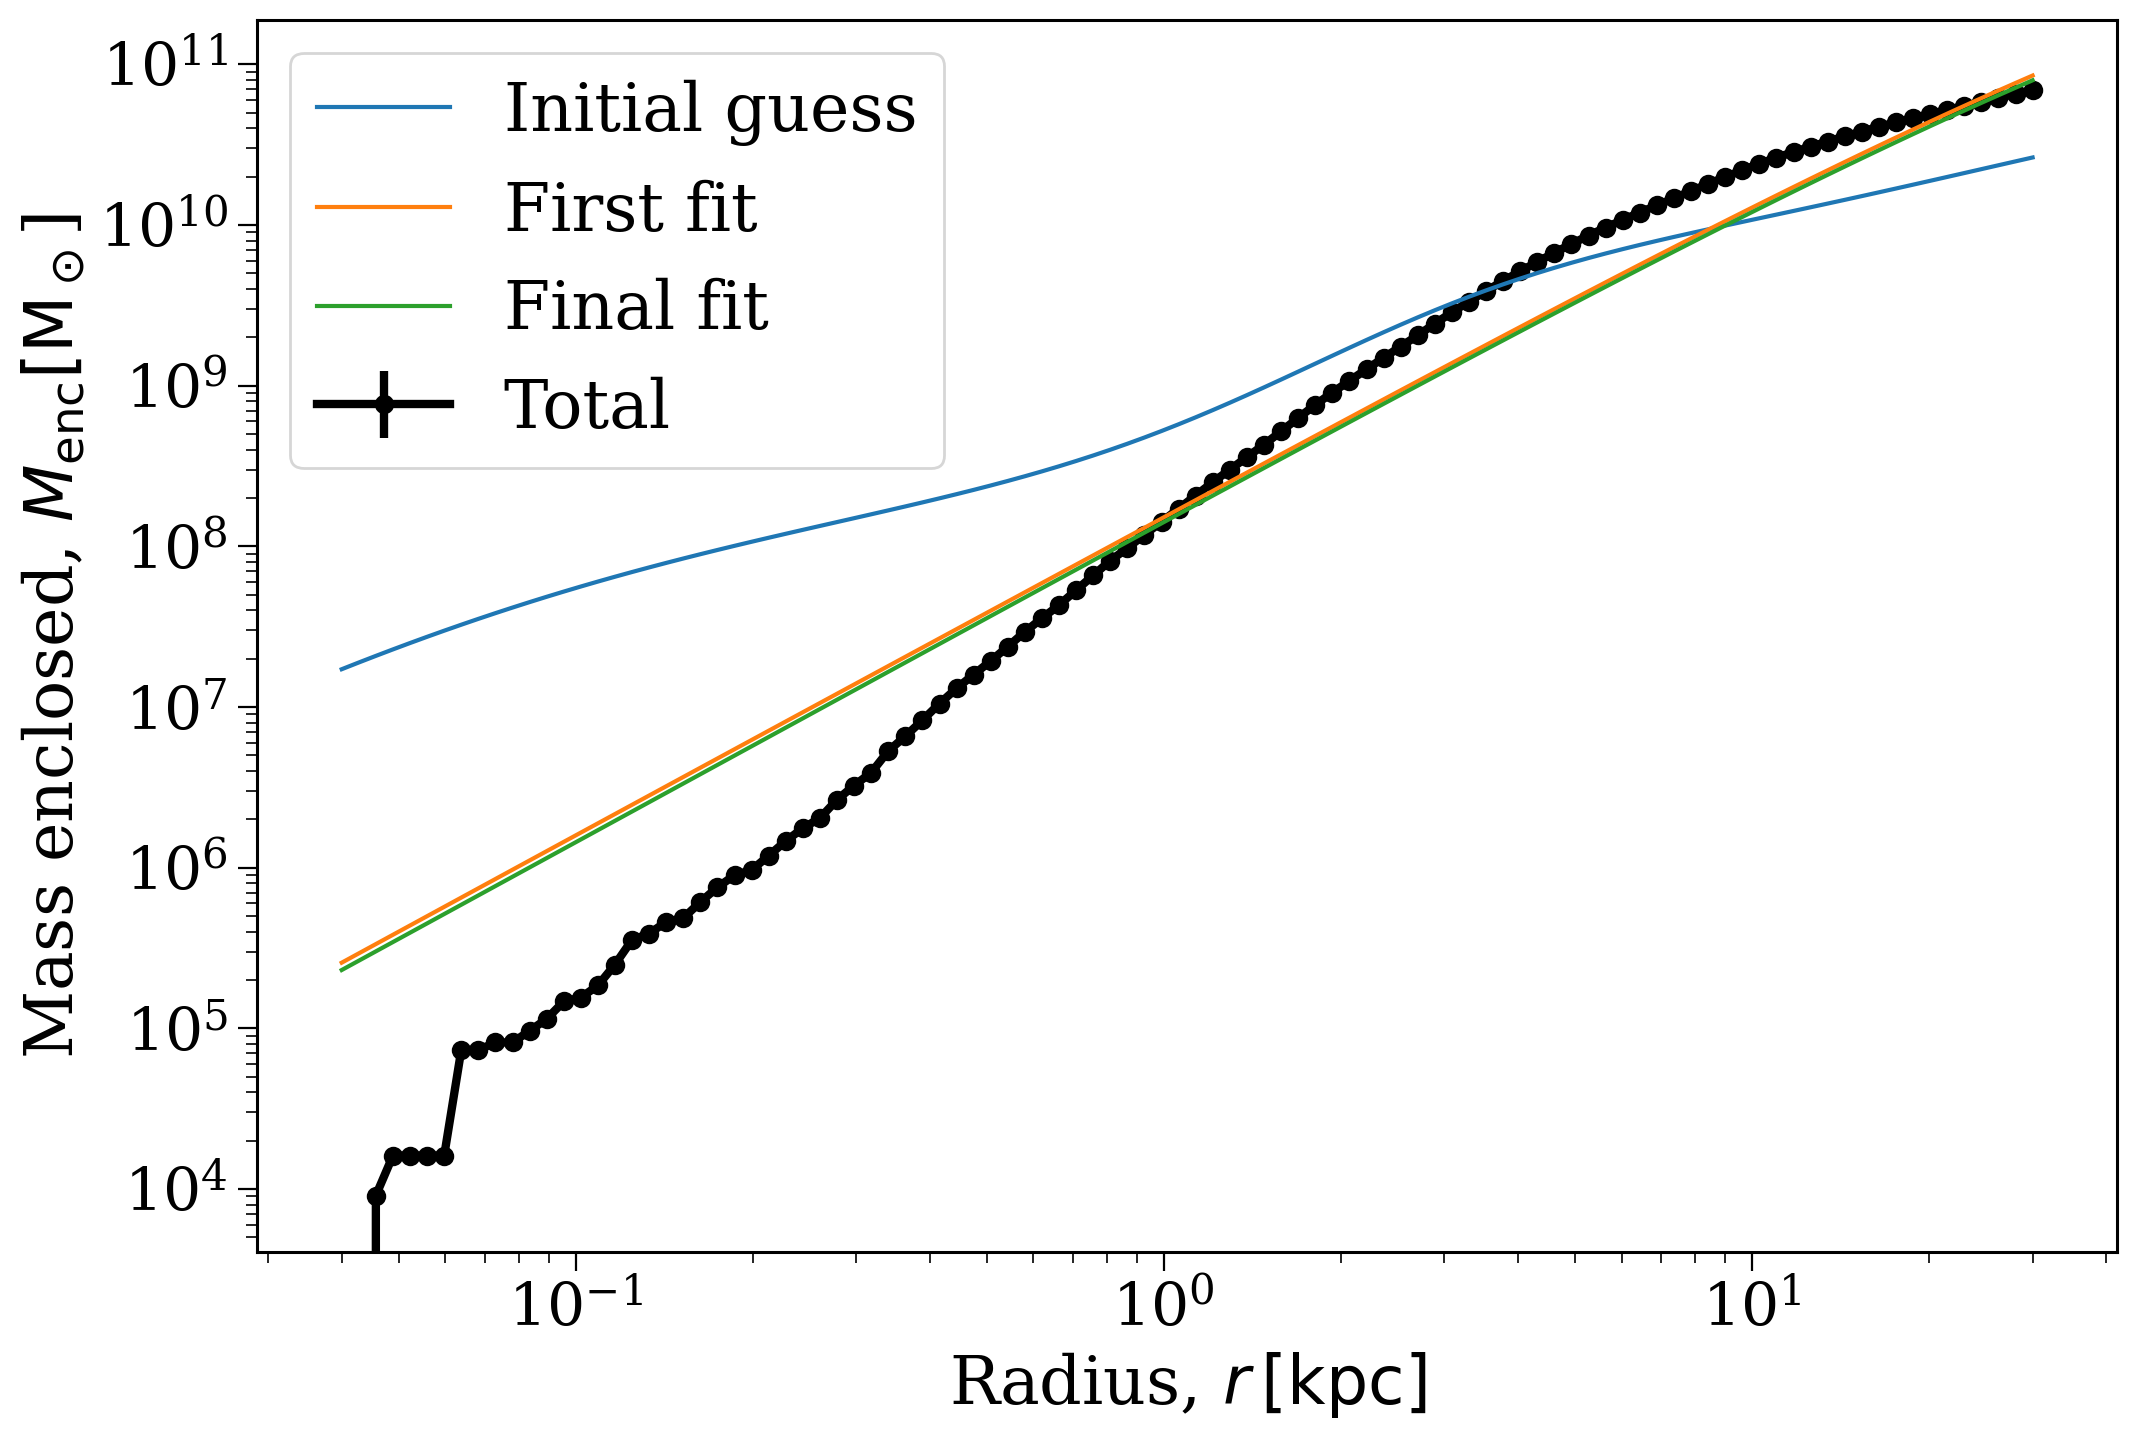

In [17]:
plt.errorbar(r_range, m_enc['total'].value, np.sqrt(m_enc['total'].value), label="Total", color="black", lw=3, zorder=-1, marker="o")

xyz = np.zeros((3, len(r_range))) * u.kpc
xyz[0] = r_range
plt.plot(r_range, init_potential.mass_enclosed(xyz), label="Initial guess")
plt.plot(r_range, fit_potential.mass_enclosed(xyz), label="First fit")
plt.plot(r_range, double_fit_potential.mass_enclosed(xyz), label="Final fit")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.xlabel(r"Radius, $r \, [\rm kpc]$")
plt.ylabel(r"Mass enclosed, $M_{\rm enc} [\rm M_\odot$]")
plt.show()

# Attempt 2: New SCF method

In [5]:
pot = gp.CompositePotential()
for label, snap, r_s in zip(["stars", "dark_matter", "gas"], [stars, dark_matter, gas], [3, 10, 3]):
    Snlm, Tnlm = gp.scf.compute_coeffs_discrete(xyz=snap.X_s.T.to(u.kpc).value,
                                                mass=snap.m.to(u.Msun).value / snap.m.sum().value,
                                                nmax=15, lmax=5, r_s=r_s, skip_m=True)

    pot[label] = gp.scf.SCFPotential(m=snap.m.sum().value, r_s=r_s, Snlm=Snlm, Tnlm=Tnlm, units=galactic)
pot.save("m11h_potential.yml")

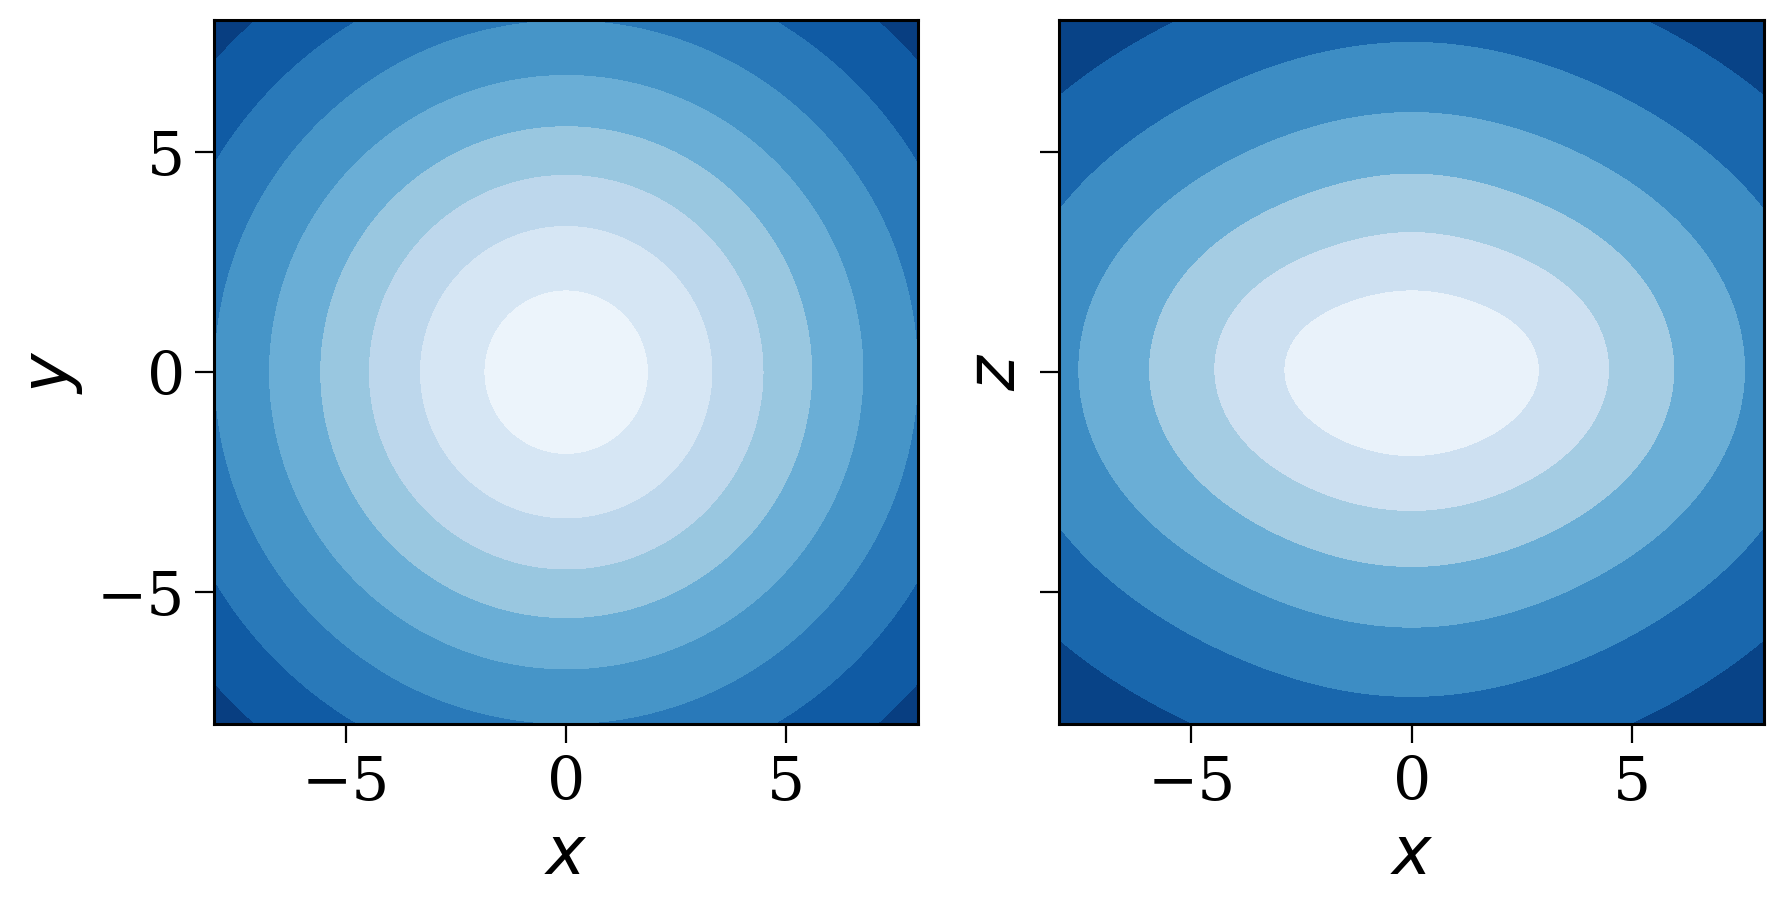

In [10]:
grid = np.linspace(-8, 8, 300)
# z_grid = np.linspace(-8, -8, 400)

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)
_ = pot.plot_contours((grid, grid, 0), ax=axes[0])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

_ = pot.plot_contours((grid, 0, grid), ax=axes[1])
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')

for ax in axes:
    ax.set_aspect('equal')

plt.show()

## Huh, that's rather spherical
Let's check how the mass distributions look with respect to the midplane

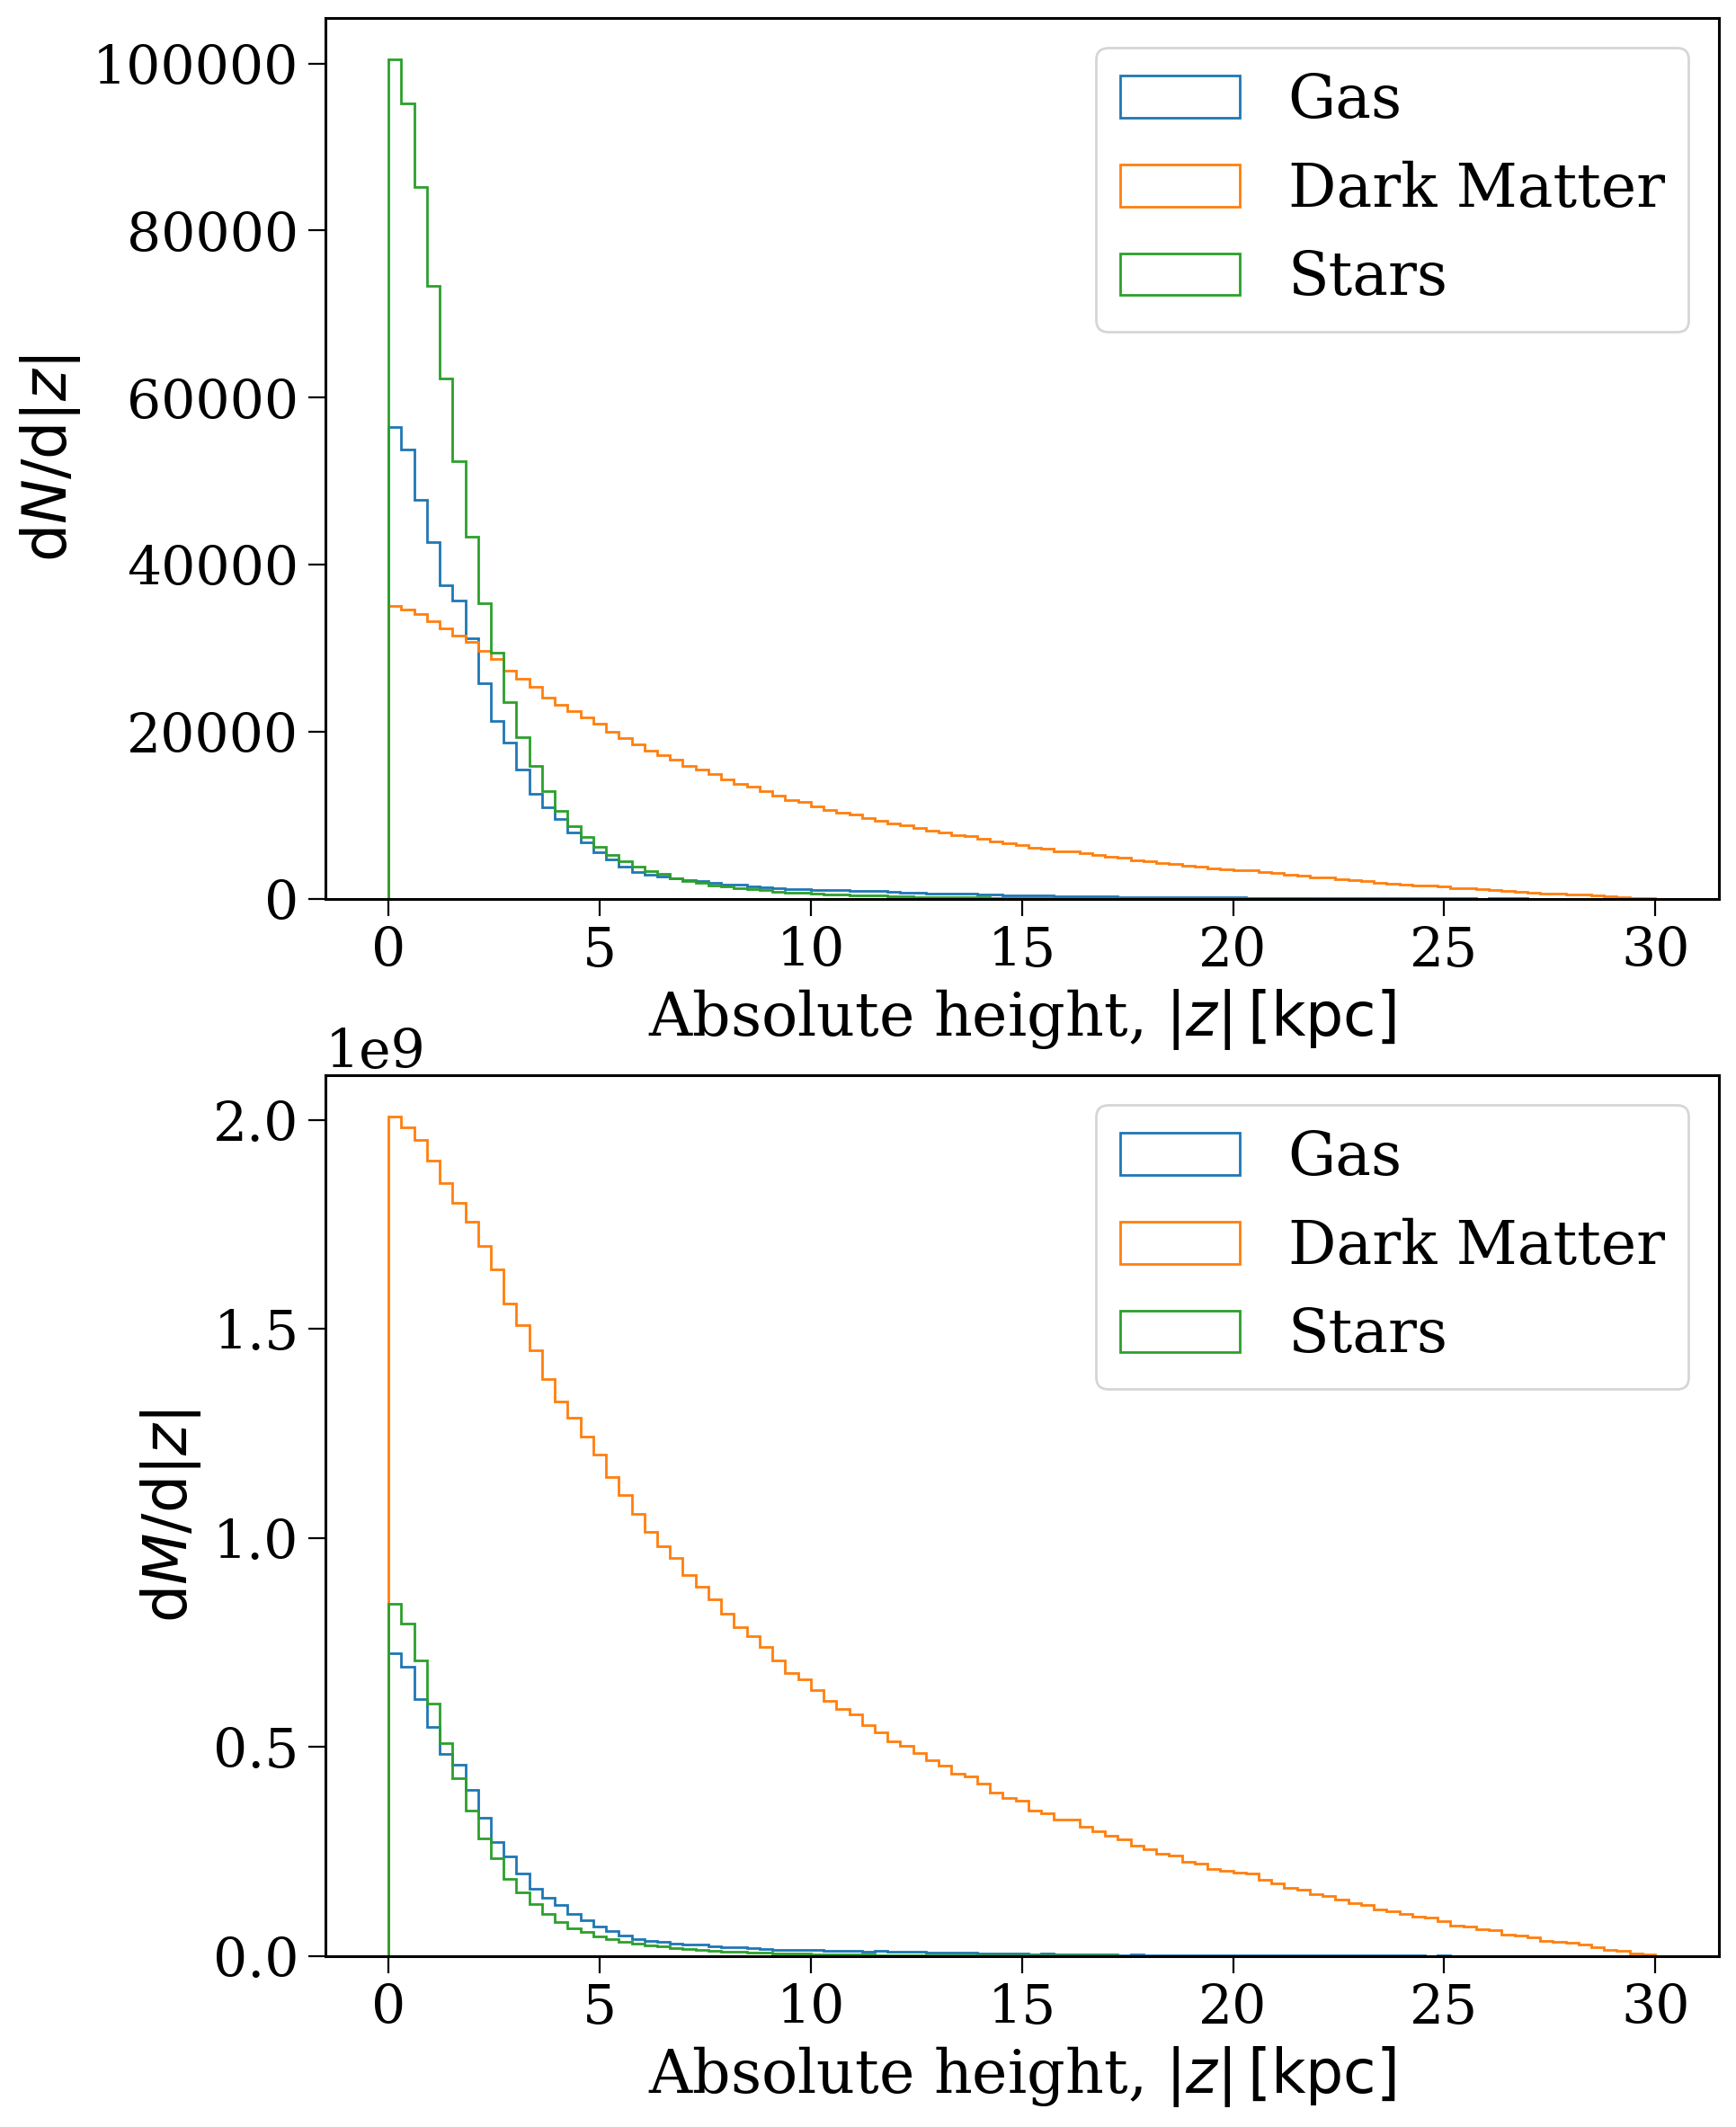

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

for particles, label in zip([gas, dark_matter, stars], ["Gas", "Dark Matter", "Stars"]):
    axes[0].hist(np.abs(particles.z), bins=np.linspace(0, 30, 100) * u.kpc, histtype="step", label=label);
axes[0].set_ylabel(r"$\mathrm{d}N/\mathrm{d}|z|$")

for particles, label in zip([gas, dark_matter, stars], ["Gas", "Dark Matter", "Stars"]):
    axes[1].hist(np.abs(particles.z), weights=particles.m, bins=np.linspace(0, 30, 100) * u.kpc, histtype="step", label=label);
axes[1].set_ylabel(r"$\mathrm{d}M/\mathrm{d}|z|$")

for ax in axes:
    ax.legend()
    ax.set_xlabel(r"Absolute height, $|z| \, [\rm kpc]$")

plt.show()

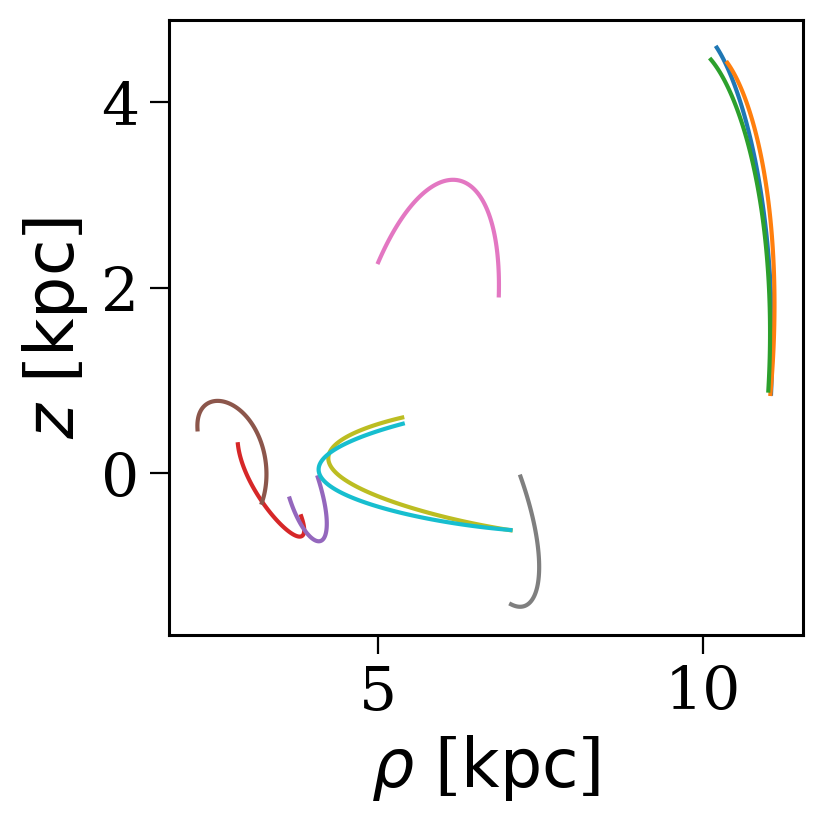

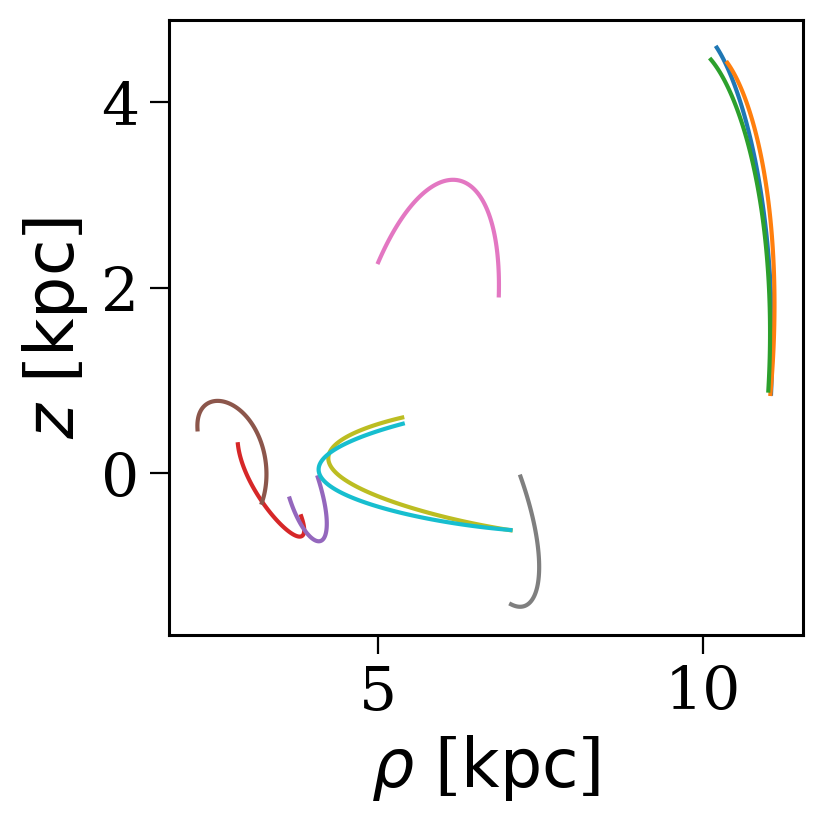

In [22]:
orbits

<Orbit cartesian, dim=3, shape=(10,)>